<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 2 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
        <th>Kaggle naam</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td><span style="color:blue">2</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
        <td><span style="color:blue">???</span></td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1 - EDA**](#eda)
- [**Opdracht 2 - LSTM voor audioclips**](#audio)
- [**Opdracht 3 - LSTM voor songteksten**](#song_lstm)
- [**Opdracht 4 - Transformer voor songteksten**](#song_tran)
- [**Opdracht 5 - Model naar keuze**](#mnk)
- [**Opdracht 6 - Bevindingen**](#bevindingen)
- [**Opdracht 7 - Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook gaan we aan de hand van songteksten en audiodata, audiotracks in verschillende genres classificeren

## Packages en de data inladen <a name='data'></a>

In [22]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from IPython import display

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/Portfolio opdracht 2')

In [25]:
#songteksten inladen

train = pd.read_csv('train.csv', index_col='filename')
test = pd.read_csv('test.csv', index_col='filename')

In [26]:
#Train en validation set inladen

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Train',
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [27]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [28]:
#test dataset inladen

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Test',
    label_mode=None,
    batch_size=32,
    seed=0,
    output_sequence_length=5*16000)

print()

Found 129 files belonging to 1 classes.



## **Opdracht 1 - EDA** <a name='eda'></a>

In [29]:
display(train.head())
display(train.info())
display(train.describe())
display(train.isnull().sum())

,lyrics,genre
filename,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


<class 'pandas.core.frame.DataFrame'>
Index: 537 entries, blues.00001.wav to rock.00099.wav
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  537 non-null    object
 1   genre   537 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


None

,lyrics,genre
count,537,537
unique,500,8
top,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,4,79


lyrics    0
genre     0
dtype: int64

(32, 80000)
(32,)


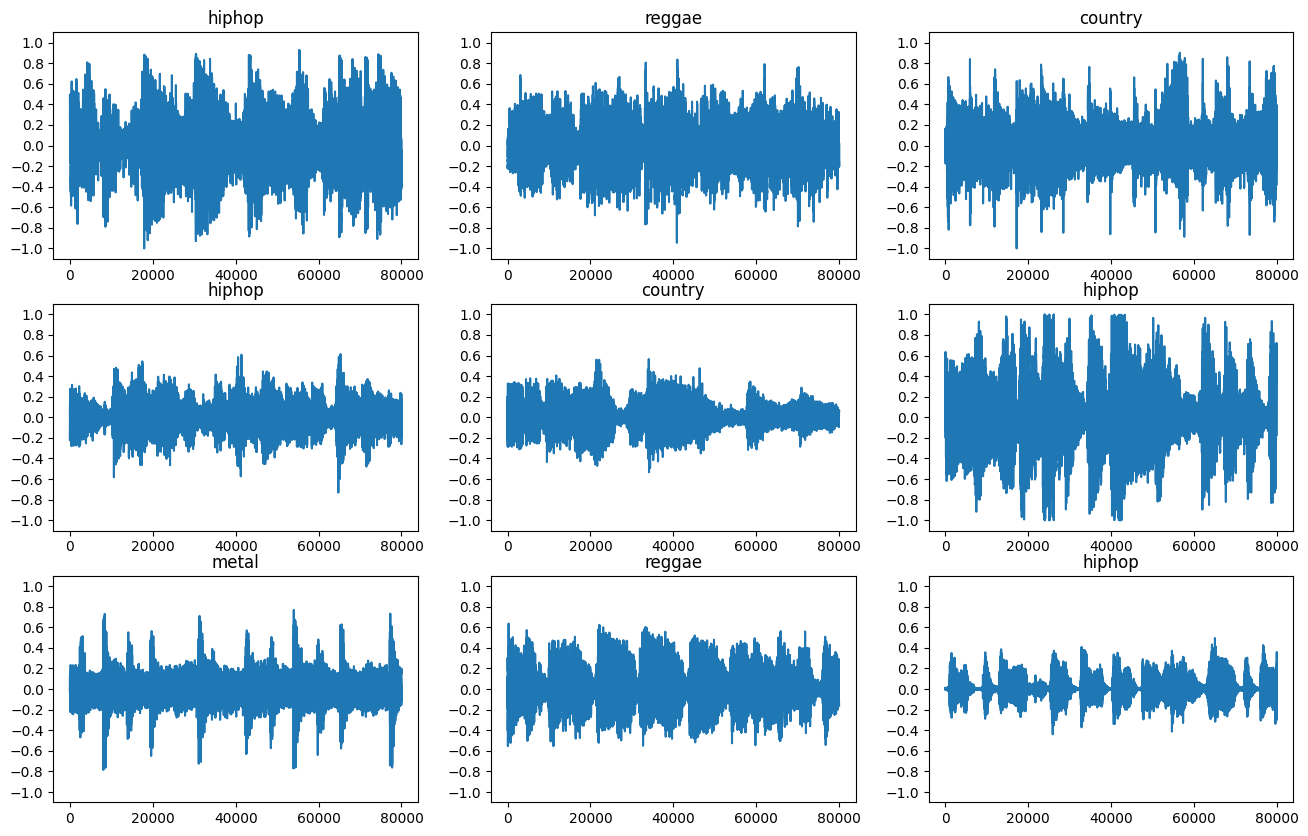

In [30]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[1,1,0,0]]
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Opdracht 2 - LSTM voor audioclips <a name='audio'></a>

## Opdracht 3 - LSTM voor songteksten <a name='song_lstm'></a>

In [31]:
import re
import nltk
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

In [32]:
# nltk.download('punkt')

In [33]:
# from sklearn.model_selection import train_test_split

In [34]:
# train_ds, val_ds = train_test_split(train, test_size=0.2, random_state=42)

In [60]:
from sklearn.preprocessing import LabelEncoder

In [68]:
genres = list(set(train['genre']))

label_encoder = LabelEncoder()

# Fit label encoder and transform the genre labels into numbers
encoded_labels = label_encoder.fit_transform(genres)

# Print the mapping between genres and encoded labels
label_mapping = dict(sorted(zip(genres, encoded_labels)))
print("Label mapping:", label_mapping)

train['genre_encoded'] = train['genre'].map(label_mapping)

display(train)

Label mapping: {'blues': 0, 'country': 1, 'disco': 2, 'hiphop': 3, 'metal': 4, 'pop': 5, 'reggae': 6, 'rock': 7}


,lyrics,genre,genre_encoded
filename,,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,0
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,0
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,0
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,0
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,0
...,...,...,...
rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,7
rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,7
rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,7


In [69]:
def df_to_dataset(dataframe, target, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dataframe['lyrics'].values, labels.values))
    ds = ds.batch(batch_size)
    return ds

In [70]:
dataframe = train[['lyrics', 'genre_encoded']]
train_ds = df_to_dataset(dataframe, 'genre_encoded')
train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size

# Shuffle and split the dataset
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)
train_ds = train_ds.take(train_size)
val_ds = train_ds.skip(train_size)

In [71]:
# def preprocess_text(text):
#     # Remove newline characters
#     text = text.replace('\n', ' ')

#     # Remove 'Verse #' and 'Chorus' lines
#     text = re.sub(r'\[Verse\s*\d*\]', '', text)
#     text = re.sub(r'\[Chorus\]', '', text)

#     # Tokenization
#     tokens = word_tokenize(text)

#     # Removing Punctuation and Special Characters
#     tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]

#     return ' '.join(tokens)

In [72]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import TextVectorization, Embedding

In [73]:
def custom_standardization(text):
    # Convert to string if not already
    text = tf.strings.as_string(text)
    # Remove new lines
    text = tf.strings.regex_replace(text, r'\n', ' ')
    # Remove anything in square brackets
    text = tf.strings.regex_replace(text, r'\[.*?\]', '')
    return text

vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
text_ds = text_ds.unbatch()  # Unbatch the dataset to get individual text samples

# Extract the text data from the dataset
texts = [text.numpy().decode('utf-8') for text in text_ds]
vectorize_layer.adapt(texts)

embedding_layer = Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64, mask_zero=True)

In [74]:
model_text_lstm = Sequential([
    vectorize_layer,
    embedding_layer,
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_text_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 677249 (2.58 MB)
Trainable params: 677249 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [75]:
epochs=15

# Compile
model_text_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          metrics=['accuracy'])

# Add early stopping to the tuning process
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
history = model_text_lstm.fit(train_ds,
                                validation_data=val_ds,
                                epochs=epochs,
                                callbacks=[stop_early])

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.0481

ValueError: Expected input data to be non-empty.

## Opdracht 4 - Transformer voor songteksten <a name='song_tran'></a>

## Opdracht 5 - Model naar keuze <a name='mnk'></a>

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>

## Bronnenlijst <a name='bronnenlijst'></a>